##Project for Digital Image Processing class  
  
Krzysztof Miśków

### Imports

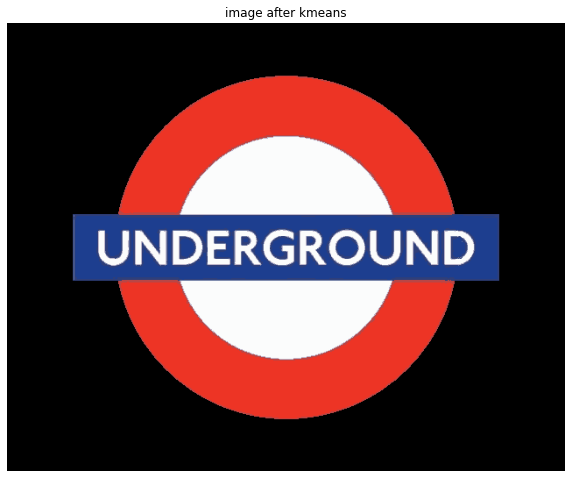

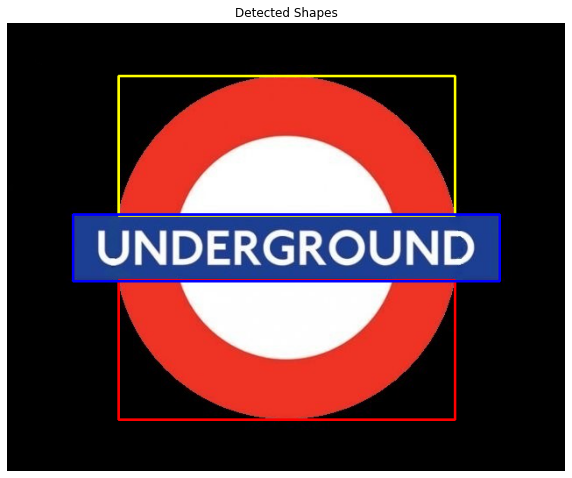

Detected shapes in template: [('lower_red_half_moon', (127, 293, 384, 159), array([ 4.50942241e-01,  1.12433252e-01,  3.30780799e-02,  4.23642577e-03,
       -5.01208848e-05, -1.42008817e-03, -1.70391272e-06]), (318, 374)), ('upper_red_half_moon', (127, 60, 384, 159), array([ 4.48706645e-01,  1.11289864e-01,  3.26084519e-02,  4.17240010e-03,
       -4.86467015e-05, -1.39159798e-03,  1.44160886e-06]), (318, 136)), ('blue_rectangle', (75, 218, 487, 76), array([ 5.62038049e-01,  2.88006988e-01,  2.50984680e-06,  2.83397022e-07,
       -2.23627854e-13, -1.46336914e-07, -8.43592510e-14]))]


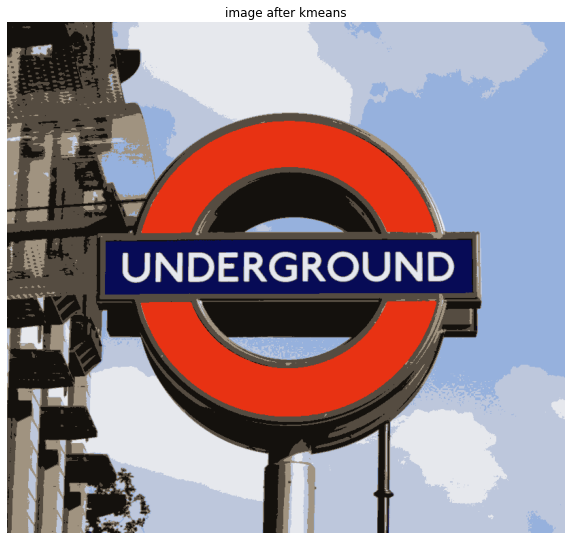

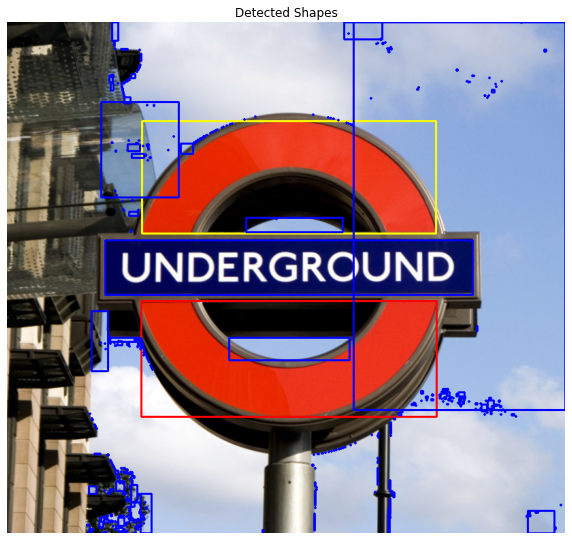

Detected shapes in test image: [('lower_red_half_moon', (197, 409, 434, 170), array([ 4.88934418e-01,  1.42195283e-01,  4.12030461e-02,  5.24716117e-03,
       -7.71462792e-05, -1.97854743e-03, -9.97257827e-07]), (413, 498)), ('upper_red_half_moon', (198, 145, 432, 165), array([ 5.09112838e-01,  1.57750977e-01,  4.59741457e-02,  5.82791395e-03,
       -9.53310002e-05, -2.31400692e-03, -3.49926518e-06]), (412, 222)), ('blue_rectangle', (140, 749, 1, 1), array([0., 0., 0., 0., 0., 0., 0.])), ('blue_rectangle', (188, 748, 1, 1), array([0., 0., 0., 0., 0., 0., 0.])), ('blue_rectangle', (171, 748, 2, 2), array([0., 0., 0., 0., 0., 0., 0.])), ('blue_rectangle', (142, 748, 4, 2), array([0., 0., 0., 0., 0., 0., 0.])), ('blue_rectangle', (166, 747, 3, 3), array([0., 0., 0., 0., 0., 0., 0.])), ('blue_rectangle', (121, 747, 3, 3), array([ 2.05761317e-01,  1.26166404e-02,  1.57587217e-03,  2.77662219e-04,
        1.70442581e-07,  2.81789404e-05, -6.84368305e-08])), ('blue_rectangle', (119, 747, 1,

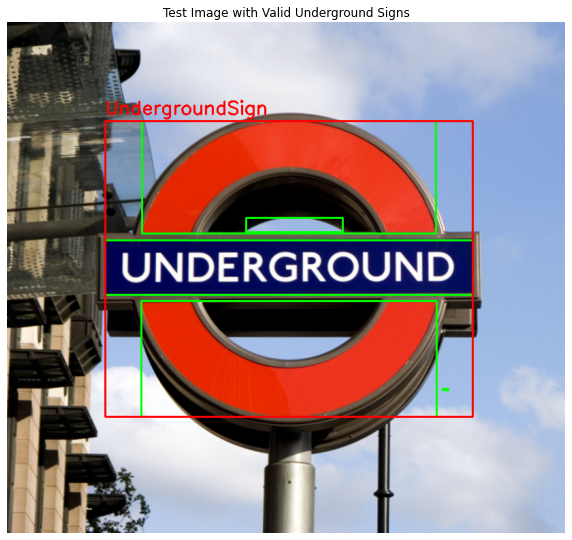

In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def display_image(image,title="Image"):
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')
    plt.show()

def reduce_colors(image, k):
    Z = image.reshape((-1, 3))
    Z = np.float32(Z)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    ret, label, center = cv2.kmeans(Z, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    center = np.uint8(center)
    res = center[label.flatten()]
    result_image = res.reshape((image.shape))
    plt.figure(figsize=(10, 10))
    plt.imshow(result_image)
    plt.title('image after kmeans')
    plt.axis('off')
    plt.show()
    return result_image, center

def detect_shapes(image_path, calculate_hu_moments=False):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


    # image_rgb = cv2.convertScaleAbs(image_rgb, alpha=2.0, beta=50)
    # display_image(image_rgb,'After processing')
   


    # Reduce colors to 8 clusters
    reduced_color_image, centers = reduce_colors(image_rgb, 8)
    hsv_image = cv2.cvtColor(reduced_color_image, cv2.COLOR_RGB2HSV)

    # Define color ranges for red and blue in HSV
    red_lower1 = np.array([0, 70, 50])
    red_upper1 = np.array([10, 255, 255])
    red_lower2 = np.array([170, 70, 50])
    red_upper2 = np.array([180, 255, 255])
    blue_lower = np.array([70, 70, 0])
    blue_upper = np.array([140, 255, 255])

    # Create masks for red and blue colors
    red_mask1 = cv2.inRange(hsv_image, red_lower1, red_upper1)
    red_mask2 = cv2.inRange(hsv_image, red_lower2, red_upper2)
    red_mask = cv2.bitwise_or(red_mask1, red_mask2)
    blue_mask = cv2.inRange(hsv_image, blue_lower, blue_upper)

    # Detect contours for red (half-moons) and blue (rectangle)
    contours_red, _ = cv2.findContours(red_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours_blue, _ = cv2.findContours(blue_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    detected_shapes = []

    image_height = image.shape[0]
    middle_y = image_height // 2

    for contour in contours_red:
        x, y, w, h = cv2.boundingRect(contour)
        moments = cv2.moments(contour)
        if moments['m00'] != 0:
            center_x = int(moments['m10'] / moments['m00'])
            center_y = int(moments['m01'] / moments['m00'])
        else:
            continue
            center_x, center_y = 0, 0
        if center_y < y+h/2:
            label = 'upper_red_half_moon'
            cv2.rectangle(image_rgb, (x, y), (x + w, y + h), (255, 255, 0), 2)
        else:
            label = 'lower_red_half_moon'
            cv2.rectangle(image_rgb, (x, y), (x + w, y + h), (255, 0, 0), 2)
        if calculate_hu_moments:
            hu_moments = cv2.HuMoments(moments).flatten()
            detected_shapes.append((label, (x, y, w, h), hu_moments, (center_x, center_y)))
        else:
            detected_shapes.append((label, (x, y, w, h), (center_x, center_y)))
        

    for contour in contours_blue:
        x, y, w, h = cv2.boundingRect(contour)
        if calculate_hu_moments:
            moments = cv2.moments(contour)
            hu_moments = cv2.HuMoments(moments).flatten()
            detected_shapes.append(('blue_rectangle', (x, y, w, h), hu_moments))
        else:
            detected_shapes.append(('blue_rectangle', (x, y, w, h)))
        cv2.rectangle(image_rgb, (x, y), (x + w, y + h), (0, 0, 255), 2)

    plt.figure(figsize=(10, 10))
    plt.imshow(image_rgb)
    plt.title('Detected Shapes')
    plt.axis('off')
    plt.show()

    return detected_shapes

def match_shapes(template_shapes, test_shapes, distance_threshold=0.1):
    matched_shapes = []

    for test_shape in test_shapes:
        best_match = None
        min_distance = float('inf')
        for template_shape in template_shapes:
            if test_shape[0] == template_shape[0]:  # Ensure same shape type
                distance = np.linalg.norm(test_shape[2] - template_shape[2])
                print(f"Matching {test_shape[0]}: distance = {distance:.5f}")  # Diagnostic print
                if distance < min_distance:
                    min_distance = distance
                    best_match = template_shape
        if best_match and min_distance < distance_threshold:
            matched_shapes.append((test_shape, best_match))
            print(f"Matched {test_shape[0]} with distance {min_distance:.5f}")  # Diagnostic print

    return matched_shapes

def check_underground_sign_combinations(matched_shapes):
    upper_halfmoons = [shape for shape in matched_shapes if shape[0][0] == 'upper_red_half_moon']
    lower_halfmoons = [shape for shape in matched_shapes if shape[0][0] == 'lower_red_half_moon']
    blue_rectangles = [shape for shape in matched_shapes if shape[0][0] == 'blue_rectangle']

    possible_signs = []
    used = []
    for upper in upper_halfmoons:
        for lower in lower_halfmoons:
            for blue in blue_rectangles:
                if blue not in used:
                    # Calculate the distance between centers of red half-moons
                    upper_center_x, upper_center_y = upper[0][3]
                    lower_center_x, lower_center_y = lower[0][3]
                    distance_between_centers = np.sqrt((upper_center_x - lower_center_x) ** 2 + (upper_center_y - lower_center_y) ** 2)
                    if distance_between_centers < 500:
                        # Check if the blue rectangle is between the upper and lower half-moons
                        upper_y = upper[0][1][1] + upper[0][1][3]
                        lower_y = lower[0][1][1]
                        blue_y = blue[0][1][1]
                        blue_height = blue[0][1][3]
                        if upper_y < blue_y and blue_y + blue_height < lower_y:
                            # Create a bounding rectangle around the three shapes
                            x_min = min(upper[0][1][0], lower[0][1][0], blue[0][1][0])
                            y_min = upper[0][1][1]
                            x_max = max(upper[0][1][0] + upper[0][1][2], lower[0][1][0] + lower[0][1][2], blue[0][1][0] + blue[0][1][2])
                            y_max = lower[0][1][1] + lower[0][1][3]
                            possible_signs.append((x_min, y_min, x_max, y_max, distance_between_centers))
                            used.append(blue)
    return possible_signs

# Detect shapes and calculate Hu moments in the template image
template_image_path = 'template.jpg'
template_shapes = detect_shapes(template_image_path, calculate_hu_moments=True)
print("Detected shapes in template:", template_shapes)

# Detect shapes and calculate Hu moments in the test image
test_image_path = 'image_test_1.jpg'


test_shapes = detect_shapes(test_image_path, calculate_hu_moments=True)
print("Detected shapes in test image:", test_shapes)

# Match shapes based on Hu moments
matched_shapes = match_shapes(template_shapes, test_shapes)
print("Matched shapes:", matched_shapes)

# Draw matched shapes on the test image
image_test = cv2.imread(test_image_path)
image_test_rgb = cv2.cvtColor(image_test, cv2.COLOR_BGR2RGB)
for match in matched_shapes:
    test_shape, template_shape = match
    x, y, w, h = test_shape[1]
    cv2.rectangle(image_test_rgb, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Check for valid combinations of upper and lower red half-moons and blue rectangle
valid_signs = check_underground_sign_combinations(matched_shapes)
print("Valid underground signs:", valid_signs)

# Draw valid underground signs on the image
for sign in valid_signs:
    x_min, y_min, x_max, y_max, _ = sign
    cv2.rectangle(image_test_rgb, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)
    cv2.putText(image_test_rgb, "UndergroundSign", (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

plt.figure(figsize=(10, 10))
plt.imshow(image_test_rgb)
plt.title('Test Image with Valid Underground Signs')
plt.axis('off')
plt.show()


In [7]:
print(upper)

NameError: name 'upper' is not defined